In [ ]:
import datetime

date = datetime.datetime.now()
print(f'Today is Happy{date: %A, %d, %m, %Y}.', '\n')

import os
from glob import glob
from itertools import combinations
import math
import random 
from random import sample
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
import scipy as sp
from scipy import stats
import scipy.stats as sp
from statannot import add_stat_annotation
import cv2 as cv
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append('../code')
from dataloader.kface16000 import KFaceDataLoader
from models import PPO, AC, DQN, CNN

sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   
sns.set_style('whitegrid', rc={'font.family': 'serif', 'font.serif': 'Times New Roman'})

### Button

In [37]:
date = '2022-11-05'
time = '11-22-42'
windows = True # True for Windows, False for MAC
train = 'SL' # 'RL' or 'SL
stim_type = 'opt' # 'opt' or 'elec'
top1 = False # True for top1, False if top2
class_num = 16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if windows:
    base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Project\\code'
    slash = '\\'
else:
    base_dir = '/Users/naminan/Development/Project/c ode'
    slash = '/'

data_dir = os.path.join(base_dir, 'data')
data_path = os.path.join(data_dir, '210827_ANNA_Removing_uncontaminated_data.csv')
label_path = os.path.join(data_dir, '211105_QAs_for_Set0_CNN_SVC_4classes_partial.csv')
pred_dir =  os.path.join(os.path.join(data_dir, 'Human_Expert'), '211202')

df = pd.read_csv(data_path)
l = list(range(df.shape[0]))
random.seed(22)
set_1 = random.sample(l, class_num)
face_lst = [df.iloc[i, 0] for i in set_1]
face_dic_r = {int(i) : str(face) for (i, face) in enumerate(face_lst)}

if stim_type == 'opt':
        image_dir = f'{data_dir}{slash}sample_for_dev_test'
elif stim_type == 'elec':
    image_dir = f'{data_dir}{slash}sample_for_dev_test2'

if train == 'RL':
    env_type = 'Bioniceye' #'CartPole-v1'
    model_type = 'DQN' # 'PPO' or 'AC' or 'DQN'
    learning_rate, gamma, lmbda, eps_clip, batch_size = None, None, None, None, None
    outputs_dir = os.path.join(base_dir, 'outputs') # {slash}date{slash}time{slash}outputs

    model_state_dict_files = glob(f'{outputs_dir}{slash}{date}{slash}{time}{slash}outputs{slash}{env_type}_{model_type}.pth', recursive=True)
    train_returns_files = glob(f'{outputs_dir}{slash}{date}{slash}{time}{slash}outputs{slash}TrainReturns_{env_type}_{model_type}.csv', recursive=True)
    correctness_files = glob(f'{outputs_dir}{slash}{date}{slash}{time}{slash}outputs{slash}Correctness_{env_type}_{model_type}.csv', recursive=True)
    model_state_dict_files = list(set(model_state_dict_files))
    model_state_dict_files.sort()
    train_returns_files.sort()
    correctness_files.sort()
    if model_type == 'DQN':
        model = DQN(16, 'Bioniceye', device)
    elif model_type == 'PPO':
        model = PPO(16, 'Bioniceye', device)
    assert len(model_state_dict_files) != 0

elif train == 'SL':
    multirun_dir = os.path.join(base_dir, 'multirun')
    model_state_dict_files = glob(f'{multirun_dir}{slash}{date}{slash}**{slash}**{slash}outputs{slash}CNN.pth', recursive=True)
    model_state_dict_files = list(set(model_state_dict_files))
    model_state_dict_files.sort()
    model_state_dict_files = [model_state_dict_files[-1]] + model_state_dict_files[1:9]
    model = CNN(16)
    assert len(model_state_dict_files) == 9

### Human data

In [38]:
if stim_type == 'opt':
  sel_ppl = list(range(300, 309)) + list(range(400, 408)) + [611] # 18 subjects
elif stim_type == 'elec': 
  sel_ppl = [499, 500] + list(range(502, 509)) + list(range(601, 607)) + list(range(608, 611)) # 18 subjects
random.seed(42)
sel_ppl = random.sample(sel_ppl, len(sel_ppl)//2)

human_df = pd.DataFrame()
preds = []
n = 9
for i in range(1, 80*n+1, 80):
    j = i+79 
    temp_df = pd.read_csv(os.path.join(pred_dir, f'main_test({i}_{j}).csv'))
    temp_df = temp_df[temp_df['유저식별아이디'].isin(sel_ppl)]
    human_df = pd.concat([human_df, temp_df], axis=1)
    # To calculate the mode
    if top1:
      temp_df = temp_df.loc[:, temp_df.columns.str.startswith('선택_A')]
      temp_df = temp_df.fillna(0)
      for k in range(len(temp_df.columns)):
          temp_preds = temp_df.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds = temp_preds[temp_preds > 0]
          temp_pred = np.bincount(temp_preds).argmax() 
          preds.append(temp_pred)
    else:
      temp_df1 = temp_df.loc[:, temp_df.columns.str.startswith('선택_A')]
      temp_df2 = temp_df.loc[:, temp_df.columns.str.startswith('선택_B')]
      temp_df1, temp_df2 = temp_df1.fillna(0), temp_df2.fillna(0)
      for k in range(len(temp_df1.columns)):
          temp_preds1 = temp_df1.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds2 = temp_df2.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds = np.concatenate([temp_preds1, temp_preds2])
          temp_preds = temp_preds[temp_preds > 0]
          temp_pred = np.bincount(temp_preds).argmax() 
          preds.append(temp_pred)  
        
orig_human_df = human_df
human_df = human_df.fillna(0)

sel_col = []
for j in range(1, 80*n+1):
  if top1:
    temp_str = f'선택_A_{j}'
    sel_col.append(temp_str)
  else:
    temp_str1 = f'선택_A_{j}'
    temp_str2 = f'선택_B_{j}'
    sel_col.append(temp_str1)
    sel_col.append(temp_str2)

human_df = human_df[sel_col]
human_df.index = sel_ppl 

if top1:
  human_df.columns = list(range(80*n))
else:
  human_df.columns = list(range(2*80*n))

question_df = pd.read_csv(label_path)

if top1:
  human_df.columns = question_df['Answer']
else:
  human_df.columns = [ans for ans in question_df['Answer'] for _ in (0, 1)]

processed_human_df = human_df.copy()
for (j, ans_file) in enumerate(processed_human_df.columns):
    face, pix, gs, par = ans_file.split('.')[0].split('_')
    act_face = int(face)
    for i in range(processed_human_df.shape[0]):
        pred_face = int(processed_human_df.iloc[i, j])
        if act_face == pred_face:
            processed_human_df.iloc[i, j] = 1.0
        else:
            processed_human_df.iloc[i, j] = 0.0

if not top1:
  processed_human_df = processed_human_df.iloc[:, 0:1440:2] + processed_human_df.iloc[:, 1:1440:2]

processed_human_df_T = processed_human_df.transpose()
face_lst, pix_lst, gs_lst, par_lst, exp_lst = [], [], [], [], []
for (i, ans_file) in enumerate(processed_human_df_T.index):
  face, pix, gs, par = ans_file.split('.')[0].split('_')
  face_lst.append(face)
  pix_lst.append(pix)
  gs_lst.append(gs)
  par_lst.append(par)
  exp_lst.append(par.split('C')[0].split('E')[-1])
processed_human_df_T['Face'] = face_lst
processed_human_df_T['PIX'] = pix_lst
processed_human_df_T['GS'] = gs_lst
processed_human_df_T['Par'] = par_lst
processed_human_df_T['Exp'] = exp_lst
processed_human_df_T['Mean'] = processed_human_df_T[sel_ppl].mean(axis=1)
processed_human_df_T['Mode'] = preds
temp_lst = list(map(int, (processed_human_df_T['Mode'].astype(int) == processed_human_df_T['Face'].astype(int)).tolist()))
processed_human_df_T['Mode'] = temp_lst


setorder_lst = [n for n in range(9)]*80
setorder_lst.sort()
processed_human_df_T['Set'] = setorder_lst

imp_par_lst = []
for i in range(processed_human_df_T.shape[0]):
  pix = processed_human_df_T['PIX'][i]
  gs = processed_human_df_T['GS'][i]
  exp = processed_human_df_T['Exp'][i]
  imp_par = f'{pix}_{gs}_{exp}' 
  imp_par_lst.append(imp_par)
processed_human_df_T['ImpPar'] = imp_par_lst

processed_human_df_T = processed_human_df_T.reset_index()
processed_human_df_T['Set'] = [idx//80+1 for idx in processed_human_df_T.index]

processed_human_df_T

,index,303,300,308,611,405,302,402,301,406,Face,PIX,GS,Par,Exp,Mean,Mode,Set,ImpPar
0,19070311_16PIX_8GS_S001L1E03C7.jpg,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,19070311,16PIX,8GS,S001L1E03C7,03,0.555556,1,1,16PIX_8GS_03
1,19080133_32PIX_4GS_S001L1E03C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,19080133,32PIX,4GS,S001L1E03C7,03,0.888889,1,1,32PIX_4GS_03
2,19090222_32PIX_8GS_S001L1E01C4.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19090222,32PIX,8GS,S001L1E01C4,01,0.333333,0,1,32PIX_8GS_01
3,19090631_16PIX_2GS_S001L1E03C7.jpg,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,19090631,16PIX,2GS,S001L1E03C7,03,0.666667,1,1,16PIX_2GS_03
4,19072221_32PIX_2GS_S001L1E01C4.jpg,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,19072221,32PIX,2GS,S001L1E01C4,01,0.666667,1,1,32PIX_2GS_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,19072221_16PIX_8GS_S001L1E01C7.jpg,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,19072221,16PIX,8GS,S001L1E01C7,01,0.777778,1,9,16PIX_8GS_01
716,19082131_16PIX_2GS_S001L1E01C7.jpg,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,19082131,16PIX,2GS,S001L1E01C7,01,0.444444,0,9,16PIX_2GS_01
717,19092521_32PIX_4GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19092521,32PIX,4GS,S001L1E01C7,01,1.000000,1,9,32PIX_4GS_01
718,19081632_64PIX_2GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19081632,64PIX,2GS,S001L1E01C7,01,1.000000,1,9,64PIX_2GS_01


### Model Results

In [39]:
hum_mod_df = processed_human_df_T.copy()

if train == 'RL':
    for i in range(len(correctness_files)):
        temp_df = pd.DataFrame()
        correctness_df = pd.read_csv(correctness_files[i], index_col=0)
        correctness_df = correctness_df.dropna(axis=1, how='all')
        preepoch = 100
        correctness_df = correctness_df.iloc[:, preepoch:]

        set_num = 9
        ques_num = correctness_df.shape[0] // set_num
        train_num = (correctness_df.shape[-1]-preepoch) // set_num 
        assert (ques_num > 0) and (train_num > 0)
        ins_num = 9
        p = preepoch 
        random.seed(77) 
        for j in range(0, correctness_df.shape[0], ques_num):
            if j == 0:
                temp_df = correctness_df[[str(n) for n in sample(list(range(p, p+train_num)), ins_num)]].iloc[j:j+ques_num, :]
                temp_df.columns = range(ins_num)
            else:
                correctness_temp_df = correctness_df[[str(n) for n in sample(list(range(p, p+train_num)), ins_num)]].iloc[j:j+ques_num, :]
                correctness_temp_df.columns = range(ins_num)
                temp_df = pd.concat([temp_df, correctness_temp_df], axis=0, ignore_index=True)
            p += train_num
    temp_df.columns = [f'M{i}' for i in range(1, ins_num+1)]
    sel_mod = [f'M{i}' for i in range(1, ins_num+1)]
    hum_mod_df[sel_mod] = temp_df
    
elif train == 'SL':
    for i in range(len(model_state_dict_files)):
        KFaceDataset = KFaceDataLoader(image_dir, data_path, label_path, class_num, 'test', None)
        test_loader = DataLoader(KFaceDataset, batch_size=1, shuffle=False)

        model = CNN(class_num).to(device)
        model.load_state_dict(torch.load(model_state_dict_files[i]))

        temp_lst = []
        model.eval()
        with torch.no_grad():
            for (image, label) in test_loader:
                image, label = image.to(device), label.to(device)
                if train == 'RL':
                    image = torch.unsqueeze(image, 0)
                    if model_type == 'PPO' or model_type == 'AC':
                        pred_probs = model.forward_pi(image.float())
                    elif model_type == 'DQN':
                        pred_probs = model(image.float())
                elif train == 'SL':
                    pred_probs = model(image)
                _, pred_label = torch.max(pred_probs, dim=-1)

                if int(pred_label) == int(label):
                    temp_lst.append(1.0)
                else:
                    temp_lst.append(0.0)

        hum_mod_df[f'M{i+1}'] = temp_lst

    sel_mod = [f'M{i}' for i in range(1, len(model_state_dict_files)+1)]
    hum_mod_df['Mean_SL'] = hum_mod_df[sel_mod].mean(axis=1) 

set_lst = [n+1 for n in range(9)] * 80
set_lst.sort()
hum_mod_df['Set'] = set_lst

hum_mod_df

,index,303,300,308,611,405,302,402,301,406,...,M1,M2,M3,M4,M5,M6,M7,M8,M9,Mean_SL
0,19070311_16PIX_8GS_S001L1E03C7.jpg,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.444444
1,19080133_32PIX_4GS_S001L1E03C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.444444
2,19090222_32PIX_8GS_S001L1E01C4.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
3,19090631_16PIX_2GS_S001L1E03C7.jpg,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.444444
4,19072221_32PIX_2GS_S001L1E01C4.jpg,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,19072221_16PIX_8GS_S001L1E01C7.jpg,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.666667
716,19082131_16PIX_2GS_S001L1E01C7.jpg,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.222222
717,19092521_32PIX_4GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
718,19081632_64PIX_2GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.888889


### Graphs

In [ ]:
# Check nan values (x-axis: ID #, 0 means there was no answer)
bin_arr = np.where(human_df.values > 0.0, 1.0, 0.0).flatten()
sns.histplot(bin_arr, color=sns.color_palette('hls', 8)[0])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 4))
plt.xticks(range(0, 2))
plt.xlabel('No answer (0) vs. filled answer (1)')
plt.title('Missing value distribution', y=1.03)
plt.show()

In [ ]:
# Check age density 
sns.histplot(data=orig_human_df['나이'], stat='density', kde=True)
plt.yticks(np.arange(0.0, 0.21, 0.05))
plt.xlabel('Age')
plt.title('Age distribution of human participants', y=1.03)
plt.legend([])
plt.show()

In [ ]:
# Draw accuracy values per set order
x = range(processed_human_df.shape[-1])
y_mean, y_stderr = processed_human_df.mean(axis=0), processed_human_df.std(axis=0) / math.sqrt(processed_human_df.shape[0])
sns.lineplot(x=x, y=y_mean, color=sns.color_palette('hls', 8)[1])
plt.fill_between(x=x, y1=y_mean - y_stderr, y2=y_mean + y_stderr, color=sns.color_palette('hls', 8)[1], alpha=0.5)
plt.xlabel('Question order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1.03)
plt.show()

In [ ]:
# Draw accuracy values per set order (with hues)
hue_order = ['16PIX_2GS_03', '16PIX_2GS_02', '16PIX_2GS_01',
             '16PIX_4GS_03', '16PIX_4GS_02', '16PIX_4GS_01',
             '16PIX_8GS_03', '16PIX_8GS_02', '16PIX_8GS_01',
             '32PIX_2GS_03', '32PIX_2GS_02', '32PIX_2GS_01',
             '32PIX_4GS_03', '32PIX_4GS_02', '32PIX_4GS_01',
             '32PIX_8GS_03', '32PIX_8GS_02', '32PIX_8GS_01',
             '64PIX_2GS_03', '64PIX_2GS_02', '64PIX_2GS_01',
             '64PIX_4GS_03', '64PIX_4GS_02', '64PIX_4GS_01',
             '64PIX_8GS_03', '64PIX_8GS_02', '64PIX_8GS_01']

plt.figure(figsize=(30, 6.5))
sns.boxplot(x='Set', y='Mean', hue='ImpPar', data=processed_human_df_T, palette=sns.color_palette("hls", 27),
            hue_order=hue_order)
plt.xlabel('Set order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1)
plt.legend(bbox_to_anchor=(1, 1.02))
plt.show()

In [ ]:
# Correlation of performances in image-level
sel_df = hum_mod_df[sel_ppl + sel_mod]
sel_df = sel_df.astype(float)
corr = sel_df.corr()
corr.index = [f'H{i}' for i in range(1, len(sel_ppl)+1)] + sel_mod
corr.columns = [f'H{i}' for i in range(1, len(sel_ppl)+1)] + sel_mod

sns.set_context("paper", rc={"axes.titlesize":12,"axes.labelsize":9, "xtick.labelsize":7, "ytick.labelsize":7})   

sns.heatmap(corr, vmin=0.0, vmax=1.0, cmap=sns.color_palette('Spectral_r', as_cmap=True))
plt.title('Correlation of Performances in Image-Level')
plt.xlabel('Human subjects (H1-H18) and Model variations (M1-M18)')
plt.ylabel('Human subjects (H1-H18) and Model variations (M1-M18)')
plt.show()

In [40]:
choose = sel_mod # sel_ppl or sel_mod
choose_title = 'Artificial Agents' # 'Human Subjects' or 'SL Models' or 'Artificial Agents'

C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\668860571.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


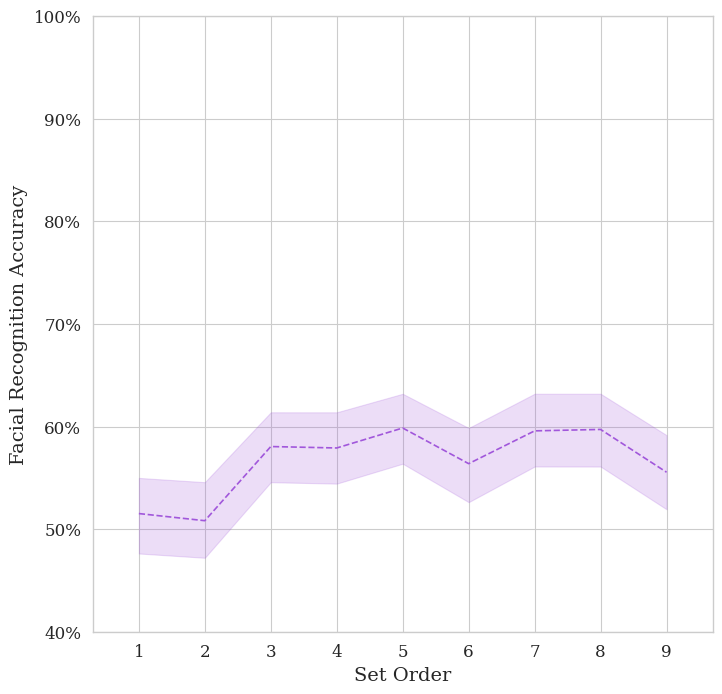

Set 1 & Set 3: ** (p=0.006)
Set 1 & Set 4: ** (p=0.007)
Set 1 & Set 5: *** (p=0.0007217)
Set 1 & Set 6: * (p=0.03)
Set 1 & Set 7: ** (p=0.001)
Set 1 & Set 8: *** (p=0.0008679)
Set 2 & Set 3: ** (p=0.003)
Set 2 & Set 4: ** (p=0.003)
Set 2 & Set 5: *** (p=0.0002806)
Set 2 & Set 6: * (p=0.02)
Set 2 & Set 7: *** (p=0.0004157)
Set 2 & Set 8: *** (p=0.0003420)
Set 2 & Set 9: * (p=0.04)
(R, p) = (0.3530246146491962, 0.0012267255187606344) , n = 81


C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\668860571.py:20: FutureWarning: ['Model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mean_std_df = hum_mod_df_temp.groupby('Set').agg(['mean', 'std'])


In [41]:
# Draw average test performance over trials
sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   

pix_lst = ['16PIX', '32PIX', '64PIX']
hum_mod_df_temp = hum_mod_df.copy()
hum_mod_df_temp.index = hum_mod_df['Set']
hum_mod_df_temp = hum_mod_df_temp[choose].stack().reset_index()
hum_mod_df_temp.columns = ['Set', 'Model', 'Mean']
plt.figure(figsize=(8, 8))
sns.lineplot(x='Set', y='Mean', data=hum_mod_df_temp, color=sns.color_palette('hls', len(pix_lst)+1)[3], linestyle='--') #sns.color_palette('hls', len(pix_lst)+1)[3], linestyle='--') # #d7bdf1 (light purple) # #7b06d9 (dark purple)
plt.xlim([0.3, 9.7])
plt.xticks(range(1, 10))
plt.ylim([0.4, 1.0])
plt.xlabel('Set Order')
plt.ylabel('Facial Recognition Accuracy')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.show()

# Save the dataframes for the correlation coefficient calculation
mean_std_df = hum_mod_df_temp.groupby('Set').agg(['mean', 'std'])
mean_std_df.to_csv(f'MeanStd_{choose_title}.csv')
hum_mod_df_temp.to_csv(f'Raw_{choose_title}.csv')

# Perform Mann-Whitney U test
for (i, j) in list(combinations(range(1, 10), 2)):
    if (i < j):
        U1, p = stats.ttest_ind(hum_mod_df_temp[hum_mod_df_temp['Set']==i]['Mean'], hum_mod_df_temp[hum_mod_df_temp['Set']==j]['Mean'],
                                alternative='less')
        if (p > 0.05):
            pass
        elif (0.01 < p <= 0.05):
            print(f'Set {i} & Set {j}: * (p={p:.2f})')
        elif (0.001 < p <= 0.01):
            print(f'Set {i} & Set {j}: ** (p={p:.3f})')
        else:
            print(f'Set {i} & Set {j}: *** (p={p:.7f})')

# Calculate the correlation of each human subject and artificial agent (n = 729, AVERAGE)
set_df = hum_mod_df.groupby('Set').mean()

x_arr, y_arr = np.array([]), np.array([])
for mod in sel_mod:
    x, y = set_df['Mean'].values, set_df[mod].values
    x_arr = np.append(x_arr, x)
    y_arr = np.append(y_arr, y)

res = stats.pearsonr(x_arr, y_arr)
print('(R, p) =', res, ', n =', len(x_arr))

(R, p) = (-0.12844492349034003, 0.2531308644912142) , n = 81


C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\2694062189.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


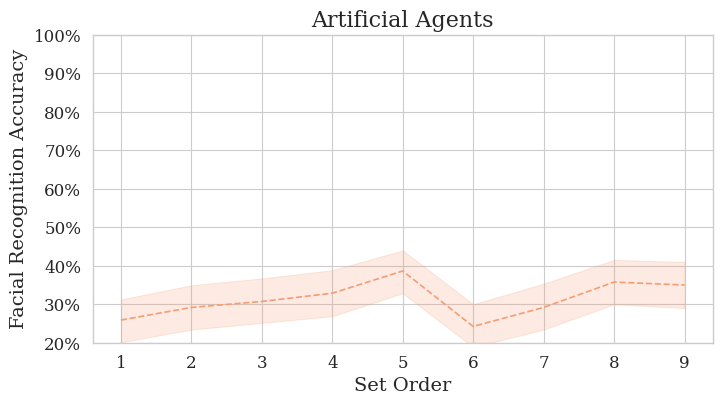

C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\2694062189.py:53: FutureWarning: ['Model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mean_std_df = pix_df.groupby('Set').agg(['mean', 'std'])


Set 1 (n=243) & Set 4 (n=234): *
Set 1 (n=243) & Set 5 (n=243): **
Set 1 (n=243) & Set 8 (n=243): **
Set 1 (n=243) & Set 9 (n=234): *
Set 2 (n=243) & Set 5 (n=243): *
Set 3 (n=234) & Set 5 (n=243): *
Set 6 (n=243) & Set 8 (n=243): **
Set 6 (n=243) & Set 9 (n=234): **
(R, p) = (0.3708320306871591, 0.000654442183266331) , n = 81


C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\2694062189.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


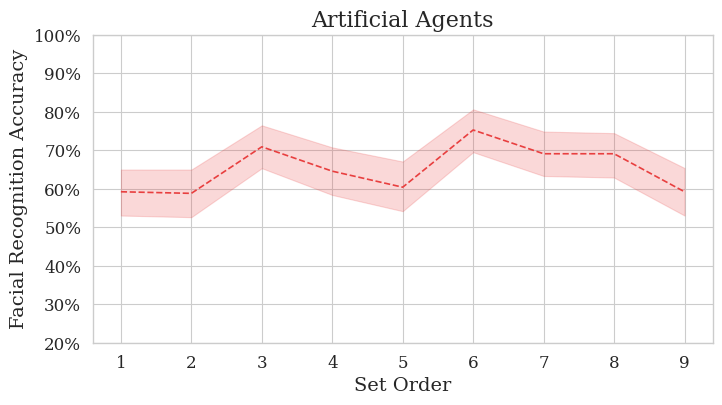

C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\2694062189.py:53: FutureWarning: ['Model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mean_std_df = pix_df.groupby('Set').agg(['mean', 'std'])


Set 1 (n=243) & Set 3 (n=234): **
Set 1 (n=243) & Set 6 (n=243): ***
Set 1 (n=243) & Set 7 (n=243): *
Set 1 (n=243) & Set 8 (n=243): *
Set 2 (n=243) & Set 3 (n=234): **
Set 2 (n=243) & Set 6 (n=243): ***
Set 2 (n=243) & Set 7 (n=243): **
Set 2 (n=243) & Set 8 (n=243): **
Set 4 (n=243) & Set 6 (n=243): **
Set 5 (n=225) & Set 6 (n=243): ***
Set 5 (n=225) & Set 7 (n=243): *
Set 5 (n=225) & Set 8 (n=243): *
(R, p) = (0.348486956655307, 0.0014315783964471871) , n = 81


C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\2694062189.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


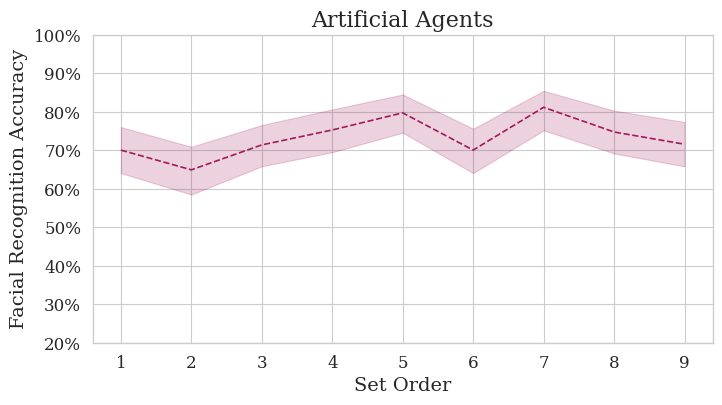

Set 1 (n=234) & Set 5 (n=252): **
Set 1 (n=234) & Set 7 (n=234): **
Set 2 (n=234) & Set 4 (n=243): **
Set 2 (n=234) & Set 5 (n=252): ***
Set 2 (n=234) & Set 7 (n=234): ***
Set 2 (n=234) & Set 8 (n=234): *
Set 3 (n=252) & Set 5 (n=252): *
Set 3 (n=252) & Set 7 (n=234): **
Set 6 (n=234) & Set 7 (n=234): **


C:\Users\Na Min An\AppData\Local\Temp\ipykernel_11132\2694062189.py:53: FutureWarning: ['Model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mean_std_df = pix_df.groupby('Set').agg(['mean', 'std'])


In [42]:
# Draw test performance over trials for each number of pixels
sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12}) 

pix_lst = ['16PIX', '32PIX', '64PIX']
for (i, pix) in enumerate(pix_lst):
    pix_df_temp = hum_mod_df[hum_mod_df['PIX'] == pix].reset_index()

    # Calculate the correlation of each human subject and artificial agent (n = 729, AVERAGE)
    set_df = pix_df_temp.groupby('Set').mean()

    x_arr, y_arr = np.array([]), np.array([])
    x = set_df['Mean'].values
    for mod in sel_mod:
        y = set_df[mod].values
        x_arr = np.append(x_arr, x)
        y_arr = np.append(y_arr, y)

    res = stats.pearsonr(x_arr, y_arr)
    print('(R, p) =', res, ', n =', len(x_arr))

    pix_df = pix_df_temp[choose].stack().reset_index() 
    pix_df.columns = ['Trial', 'Model', 'Mean']

    # Performances in set-level
    pix_df_temp.index = pix_df_temp['Set']
    pix_df = pix_df_temp[choose].stack().reset_index() 
    pix_df.columns = ['Set', 'Model', 'Mean']
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='Set', y='Mean', data=pix_df, color=sns.color_palette('rocket_r', len(pix_lst)+1)[i], linestyle='--')
    plt.ylim([0.2, 1.0])
    plt.xlabel('Set Order')
    plt.ylabel('Facial Recognition Accuracy')
    plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
    plt.title(f'{choose_title}')
    plt.show()

    # Perform Mann-Whitney U test
    for (i, j) in list(combinations(range(1, 10), 2)):
        if (i < j):
            x = pix_df[pix_df['Set']==i]['Mean']
            y = pix_df[pix_df['Set']==j]['Mean']
            U1, p = stats.ttest_ind(x, y, alternative='less')
            if (p > 0.05):
                pass
            elif (0.01 < p <= 0.05):
                print(f'Set {i} (n={x.shape[0]}) & Set {j} (n={y.shape[0]}): *')
            elif (0.001 < p <= 0.01):
                print(f'Set {i} (n={x.shape[0]}) & Set {j} (n={y.shape[0]}): **')
            else:
                print(f'Set {i} (n={x.shape[0]}) & Set {j} (n={y.shape[0]}): ***')
    
    # Save the dataframes for the correlation coefficient calculation
    mean_std_df = pix_df.groupby('Set').agg(['mean', 'std'])
    mean_std_df.to_csv(f'MeanStd_{choose_title}_{pix}.csv')

    

In [ ]:
# Draw accuracy values per set order
plt.figure(figsize=(30, 1))
x = range(processed_human_df_T.shape[0])
sns.scatterplot(x=x, y='Mode', data=processed_human_df_T, color=sns.color_palette('hls', 8)[2])
plt.xlim([0, 720])
plt.xlabel('Trial order')
plt.ylabel('Correctness')
plt.title('Facial recognition accuracy change over the human experiment', y=1.03)
plt.show()

for i in range(2):
    count = pd.Series.value_counts(processed_human_df_T['Mode'])[i]
    tot_count = pd.Series.count(processed_human_df_T['Mode'])
    ratio = count / tot_count
    print(f"Ratio of {i}'s: {ratio : .2f}")

In [ ]:
# Draw accuracy plots based on PIX & GS
processed_human_df_T = processed_human_df_T.sort_values(by=['PIX', 'GS'])

sns.lineplot(x='PIX', y='Mean', data=processed_human_df_T, hue='GS', err_style='band', ci=90, palette=sns.color_palette('flare', 3), legend=True, marker='o', markersize=7)
plt.ylim([0.2, 1])
plt.xticks(np.arange(3), labels=['16 PIX', '32 PIX', '64 PIX'])
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('The number of pixels')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='Grayscales', labels=['2 GS', '4 GS', '8 GS'])
plt.show()

sns.lineplot(x='PIX', y='Mode', data=processed_human_df_T, hue='GS', err_style='band', ci=90, palette=sns.color_palette('flare', 3), legend=True, marker='o', markersize=7)
plt.ylim([0, 1])
plt.xticks(np.arange(3), labels=['16 PIX', '32 PIX', '64 PIX'])
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('The number of pixels')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='Grayscales', labels=['2 GS', '4 GS', '8 GS'])
plt.show()


In [ ]:
# Draw accuracy plots based on pars
processed_human_df_T = processed_human_df_T.sort_values(by='Par')
hue_order = [('16PIX', '2GS'), ('16PIX', '4GS'), ('16PIX', '8GS'),
             ('32PIX', '2GS'), ('32PIX', '4GS'), ('32PIX', '8GS'),
             ('64PIX', '2GS'), ('64PIX', '4GS'), ('64PIX', '8GS')]

sns.lineplot(x='Par', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('Facial parameters')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

sns.lineplot(x='Par', y='Mode', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('Facial parameters', y=1.5)
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

In [ ]:
# Check p-values for the averaged pars
box_pairs = [('S001L1E01C10', 'S001L1E01C4'),
             ('S001L1E01C10', 'S001L1E01C7'),
             ('S001L1E01C10', 'S001L1E02C7'),
             ('S001L1E01C10', 'S001L1E03C7'),
             ('S001L1E01C4', 'S001L1E01C7'),
             ('S001L1E01C4', 'S001L1E02C7'),
             ('S001L1E01C4', 'S001L1E03C7'),
             ('S001L1E01C7', 'S001L1E02C7'),
             ('S001L1E01C7', 'S001L1E03C7'),
             ('S001L1E02C7', 'S001L1E03C7')]

plot = sns.lineplot(x='Par', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7)
plot, test_results = add_stat_annotation(plot, data=processed_human_df_T, x='Par', y='Mean',
                                         box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=1)
plt.show()

In [ ]:
# Draw accuracy plots based on faces
processed_human_df_T = processed_human_df_T.sort_values(by='Face')
hue_order = [('16PIX', '2GS'), ('16PIX', '4GS'), ('16PIX', '8GS'),
             ('32PIX', '2GS'), ('32PIX', '4GS'), ('32PIX', '8GS'),
             ('64PIX', '2GS'), ('64PIX', '4GS'), ('64PIX', '8GS')]

sns.lineplot(x='Face', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('Human facial IDs')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

sns.lineplot(x='Face', y='Mode', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('Human facial IDs', y=1.5)
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

- Training curves

In [ ]:
# Check average train returns
train_returns_df = pd.DataFrame()
for (i, file_path) in enumerate(train_returns_files):
    train_returns_df_temp = pd.read_csv(file_path, index_col=0)
    train_returns_df_temp = train_returns_df_temp.transpose().stack().to_frame().reset_index()
    train_returns_df_temp.columns = ['Epochs', 'Timestamps', 'Reward']
    train_returns_df_temp['Models'] = [file_path.split('.')[0].split(f'{slash}')[-1].split('_')[-1]] * train_returns_df_temp.shape[0]
    if i == 0:
        train_returns_df = train_returns_df_temp
    else:
        train_returns_df = pd.concat([train_returns_df, train_returns_df_temp], axis=0)
train_returns_df = train_returns_df.reset_index()
train_returns_df['Epochs'] = train_returns_df['Epochs'].astype(int)

model_order = ['DQN', 'AC', 'PPO', 'REINFORCE']
if env_type == 'CartPole-v1':
    train_returns_df = train_returns_df.groupby(['Epochs', 'Models']).agg('sum').reset_index()

sns.lineplot(x='Epochs', y='Reward', data=train_returns_df, err_style='band', palette='husl', hue='Models', hue_order=model_order)

plt.xticks(range(0, train_returns_df['Epochs'].max() + 2, (train_returns_df['Epochs'].max() + 1) // 5))
plt.xlabel('Training episodes')
plt.ylabel('Average reward per episode')

if env_type == 'CartPole-v1':
    plt.ylim([0, 510])
    plt.legend(loc='lower right')
plt.title('Training curves', y=1.03)
plt.show()

In [ ]:
for (i, model_file) in enumerate(model_state_dict_files):
    model_name = model_file.split(f'{slash}')[-1].split('.')[0].split('_')[-1]
    model_name = 'PPO'
    temp_df = train_returns_df[train_returns_df['Models']==model_name]

    sns.lineplot(x='Epochs', y='Reward', data=temp_df, err_style='band', color=sns.color_palette('hls', 6)[5]) 
    plt.xticks(range(0, train_returns_df['Epochs'].max() + 2, (train_returns_df['Epochs'].max() + 1) // 5))
    plt.xlabel('Training Episodes')
    plt.ylabel(f'Average Reward')
    if env_type == 'CartPole-v1':
        plt.ylim([0, 510])
        plt.legend(loc='lower right')
    else:
        plt.ylim([0, 1])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
    plt.show()

- Model weights

In [ ]:
# visualize the weights for the best saved model
img_num_row = 8
for file in model_state_dict_files:
    print(file)
    model_dict = torch.load(file)
    for (i, layer_name) in enumerate(model_dict):
        layer_weights = model_dict[layer_name].cpu()
        print(layer_name, layer_weights.shape)

        if layer_name.split('.')[-1] == 'weight':
            if layer_name.split('.')[0] == 'cnn_num_block':
                fig, axes = plt.subplots(layer_weights.shape[0]//img_num_row, img_num_row, figsize=(img_num_row, layer_weights.shape[0]//img_num_row))
                for j in range(layer_weights.shape[0]):
                    axes[j//img_num_row, j%img_num_row].imshow(layer_weights[j, 0, :, :])
                    axes[j//img_num_row, j%img_num_row].set_xticklabels([])
                    axes[j//img_num_row, j%img_num_row].set_yticklabels([])
                    axes[j//img_num_row, j%img_num_row].axis('off')
            elif layer_name.split('.')[0] == 'linear_num_block_pi':
                layer_weights = layer_weights.mean(axis=-1)
                plt.plot(layer_weights)
                plt.xlabel('Artificial Neuron #')
                plt.ylabel('Learned Activation Value')
            plt.show()

In [ ]:
# Load image
img = cv.imread('C:\\Users\\Na Min An\\Desktop\\Development\\Project\\code\\data\\sample_for_dev_test\\19090222\\32PIX_4GS_S001L1E01C7.jpg', cv.IMREAD_GRAYSCALE)
img = np.array(img.astype(np.float32))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

img = torch.Tensor(img)
img = torch.unsqueeze(img, axis=0)
if train == 'RL':
    img = img.to(device)
print(img.shape)


# Load model
model.load_state_dict(torch.load(model_state_dict_files[0]))
print(model)


# Concatenate info about layers
model_weights, layers = [], []
features = model.cnn_num_block
if train == 'RL':
    linears = model.linear_num_block_pi
elif train == 'SL':
    linears = model.linear_num_block

for i in range(len(features)):
    if type(features[i]) != torch.nn.modules.activation.ReLU:
        layers.append(features[i])
        if type(features[i]) == torch.nn.Conv2d:
            model_weights.append(features[i].weight)

for i in range(len(linears)):
    if type(features[i]) != torch.nn.modules.activation.ReLU:
        model_weights.append(linears[i].weight)
        layers.append(linears[i])

print("Total # of conv and linear layers: ", len(model_weights))
print("Total # of layers except for ReLU: ", len(layers))


# Propagate the image into each layer of the model
ReLU = torch.nn.ReLU()
out = [layers[0](img)]
print(out[0].shape)

for i in range(1, len(layers)):
    try:
        print(layers[i](out[-1]).shape)
        if type(layers[i]) == torch.nn.Conv2d:
            out.append(layers[i](out[-1]))
        else:
            out.append(layers[i](ReLU(out[-1])))
    except:
        print(layers[i](torch.flatten(out[-1])).shape)
        if i != len(layers)-1:
            out.append(layers[i](torch.flatten(out[-1])))
        else:
            out.append(layers[i](ReLU(out[-1])))


In [ ]:
img_num_row = 16
for layer_num in range(len(out)):
    layer_vis = out[layer_num].data
    filt_num = out[layer_num].shape[0]
    
    if len(out[layer_num].size()) > 1:
        plt.figure(figsize=(img_num_row, filt_num//img_num_row))
        for (i, filter) in enumerate(layer_vis):
            filter = filter.cpu().numpy()
            plt.subplot(filt_num//img_num_row, img_num_row, i+1)
            plt.imshow(filter, cmap='gray')
            plt.axis('off')
    else:
        plt.plot(layer_vis.cpu().numpy())
    plt.tight_layout(pad=0.0)
    plt.show()
